##### Import

In [1]:
import warnings
import papermill as pm
import scrapbook as sb
import pandas as pd
import numpy as np
from scipy.stats import spearmanr
from tqdm import tqdm
import shap
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
# from sklearn.linear_model import LinearRegression, Ridge, Lasso
# from sklearn.pipeline import Pipeline
import os
import gc
import sys

# Filter out warning messages
warnings.filterwarnings('ignore')

# Set pandas display options
pd.set_option('display.max_columns', 10000)
pd.set_option('display.max_rows', 10000)

# Set seaborn style
sns.set_style('whitegrid')

# Add the parent directory to sys.path
sys.path.insert(1, os.path.join(sys.path[0], '..'))

# Index and deciles for data slicing
idx = pd.IndexSlice

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
# from pathlib import Path
# import pandas as pd
# from utils import rank_stocks_and_quantile
# # UNSEEN_KEY = '/data/YEAR_20220803_20230803'
# top = 250  # parameters -> papermill
# DATA_STORE = Path(f'data/{top}_dataset.h5')
# with pd.HDFStore(DATA_STORE) as store:
#     # unseen = store[UNSEEN_KEY]
#     print(store.keys())

In [3]:
import gc
import pandas as pd
from utils import rank_stocks_and_quantile

top = 500  # parameters -> papermill

DATA_STORE = Path(f'data/{top}_dataset.h5')
dataset_keys = [
    '/data/YEAR_20200930_20220802',
    '/data/YEAR_20181024_20200929',
    '/data/YEAR_20161116_20181023',
    '/data/YEAR_20141210_20161115'
]
target_string = 'TARGET_ret_fwd'  # no longer a parameter

# Initialize empty dataset
dataset = pd.DataFrame()

with pd.HDFStore(DATA_STORE) as store:
    for key in dataset_keys:
        df = store[key]
        dataset = pd.concat([dataset, df], ignore_index=False)
        del df
        gc.collect()  # Explicitly call garbage collector

# Rank stocks and quantile
dataset = rank_stocks_and_quantile(dataset, target_substring=target_string)

# Adjust timezone
dataset.index.set_levels(dataset.index.levels[0].tz_localize(None), level=0, inplace=True)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 968461 entries, (Timestamp('2014-12-10 00:00:00'), 'AA') to (Timestamp('2022-08-02 00:00:00'), 'ZTS')
Columns: 628 entries, FEATURE_open to TARGET_ret_fwd_252d_rank_quantiled
dtypes: float32(365), float64(44), int32(198), int64(12), int8(9)
memory usage: 2.4+ GB


In [4]:
import pandas as pd

# Extract the first and last dates from the MultiIndex
start_date = dataset.index.get_level_values(0).min()
end_date = dataset.index.get_level_values(0).max()

# Generate business dates between the start and end date
business_dates = pd.bdate_range(start_date, end_date)

# Count the number of business days
num_business_days = len(business_dates)

print(f"Number of business days between {start_date} and {end_date}: {num_business_days}")

Number of business days between 2014-12-10 00:00:00 and 2022-08-02 00:00:00: 1995


In [5]:
def sharpe_ratio_lgbm(preds, train_data):
    """Custom Sharpe ratio eval metric for lightgbm."""
    labels = train_data.get_label()
    if not isinstance(train_data.data.index, pd.MultiIndex):
        raise ValueError("Expecting a MultiIndex with date as the first level")

    grouped_labels = pd.Series(labels, index=train_data.data.index).groupby(level=0)
    grouped_preds = pd.Series(preds, index=train_data.data.index).groupby(level=0)

    daily_scores = []
    for (_, actuals_for_day), (_, preds_for_day) in zip(grouped_labels, grouped_preds):
        score_for_day = spearmanr(actuals_for_day, preds_for_day)[0]
        daily_scores.append(score_for_day if not np.isnan(score_for_day) else 0)

    sharpe_ratio = np.mean(daily_scores) / (np.std(daily_scores) + 1e-9)
    return 'sharpe_ratio', sharpe_ratio, True


def mean_ic_for_fold(preds, train_data):
    """Compute average IC for the entire fold."""
    labels = train_data.get_label()
    if not isinstance(train_data.data.index, pd.MultiIndex):
        raise ValueError("Expecting a MultiIndex with date as the first level")

    grouped_labels = pd.Series(labels, index=train_data.data.index).groupby(level=0)
    grouped_preds = pd.Series(preds, index=train_data.data.index).groupby(level=0)

    daily_ic_scores = []
    for (_, actuals_for_day), (_, preds_for_day) in zip(grouped_labels, grouped_preds):
        ic_score_for_day = spearmanr(actuals_for_day, preds_for_day)[0]
        daily_ic_scores.append(ic_score_for_day if not np.isnan(ic_score_for_day) else 0)

    return 'IC', np.mean(daily_ic_scores), True

def mean_custom_metrics_for_fold(preds, train_data):
    """Compute average MAE, MSE, RMSE, and R^2 for the entire fold."""
    from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

    labels = train_data.get_label()
    if not isinstance(train_data.data.index, pd.MultiIndex):
        raise ValueError("Expecting a MultiIndex with date as the first level")

    grouped_labels = pd.Series(labels, index=train_data.data.index).groupby(level=0)
    grouped_preds = pd.Series(preds, index=train_data.data.index).groupby(level=0)

    mae_scores, mse_scores, rmse_scores, r2_scores = [], [], [], []
    for (_, actuals_for_day), (_, preds_for_day) in zip(grouped_labels, grouped_preds):
        mae_scores.append(mean_absolute_error(actuals_for_day, preds_for_day))
        mse_scores.append(mean_squared_error(actuals_for_day, preds_for_day))
        rmse_scores.append(np.sqrt(mse_scores[-1]))
        r2_scores.append(r2_score(actuals_for_day, preds_for_day))

    return [('MAE', np.mean(mae_scores), False),
            ('MSE', np.mean(mse_scores), False),
            ('RMSE', np.mean(rmse_scores), False),
            ('R2', np.mean(r2_scores), True)]

def combined_fold_metrics(preds, train_data):
    ic_result = mean_ic_for_fold(preds, train_data)
    sharpe_ratio_result = sharpe_ratio_lgbm(preds, train_data)
    custom_metrics_results = mean_custom_metrics_for_fold(preds, train_data)
    
    return [ic_result, sharpe_ratio_result] + custom_metrics_results

In [6]:
def compute_fold_metrics(era_scores, weights=None):
    era_scores = pd.Series(era_scores)
    
    # Calculate metrics
    mean_correlation = np.mean(era_scores)
    std_deviation = np.std(era_scores)
    sharpe_ratio = mean_correlation / std_deviation
    max_dd = (era_scores.cummax() - era_scores).max()

    # Smart Sharpe
    smart_sharpe = mean_correlation \
        / (std_deviation + np.std(era_scores.diff()))
    
    # Autocorrelation
    autocorrelation = era_scores.autocorr()

    metrics = pd.Series({
        'mean_correlation': mean_correlation,
        'std_deviation': std_deviation,
        'sharpe_ratio': sharpe_ratio,
        'smart_sharpe': smart_sharpe,
        'autocorrelation': autocorrelation,
        'max_dd': max_dd,
        'min_correlation': era_scores.min(),
        'max_correlation': era_scores.max(),
    })

    if weights:
        normalized_metrics = (metrics - metrics.min()) / (metrics.max() - metrics.min())
        weighted_values = normalized_metrics.multiply(pd.Series(weights))
        metrics["weighted_score"] = weighted_values.sum()

    _ = gc.collect()

    return metrics

In [7]:
import numpy as np

def custom_loss(preds, dataset):
    y = dataset.get_label()
    mse_gradient = 2 * (preds - y)
    corr_gradient = - (np.mean(y) - preds)
    
    gradient = mse_gradient + corr_gradient

    # For simplicity, setting hessian to ones.
    hessian = np.ones_like(y)

    return gradient, hessian

In [8]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import optuna
import mlflow
import mlflow.lightgbm
from optuna.integration import LightGBMPruningCallback
from scipy.stats import spearmanr
import warnings

warnings.filterwarnings('ignore')

evals_result = {}

def get_categoricals(dataset, threshold):
    return [col for col in dataset.columns if \
            dataset[col].nunique() < threshold and \
            dataset[col].ge(0).all() and col.startswith("FEATURE_")]

def objective(trial, data, features):
    # Dynamic categoricals based on the trial's suggested threshold
    cat_threshold = trial.suggest_int('cat_threshold', 5, 50)
    categoricals = get_categoricals(data, cat_threshold)
    # Define the features and label columns
    # features = [col for col in dataset.columns if col.startswith('FEATURE_')]
    params = {
        'boosting': 'gbdt',
        'objective': 'regression', # custom_loss,
        'verbose': -1,
        'metric': 'None',
        'device': 'gpu',
        'num_leaves': trial.suggest_int('num_leaves', 30, 150),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1, log=True),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        # 'lookahead': trial.suggest_int('lookahead', [1, 5, 21])  # Suggest lookahead as a parameter
        'lookahead': trial.suggest_categorical('lookahead', [1, 5, 21]),
        'x': trial.suggest_int('x', 8, 12),
        'val_period_length': trial.suggest_categorical('val_period_length', [5, 10, 21])
        # 'train_period_length': trial.suggest_categorical('train_period_length', [5, 10, 21])

    }

    early_stopping = lgb.early_stopping(stopping_rounds=500, verbose=True, first_metric_only=True)
    # daily_scores_in_fold = []
    daily_sharpe_in_fold = []

    # Instantiate the CV object
    cv = CustomBackwardMultipleTimeSeriesCV(dataset, train_period_length= int(21 * params['x']), 
                                        test_period_length=params['val_period_length'], 
                                        lookahead=1,  # Starting value; we'll adjust it next.
                                        date_idx='date')

    # Update the CV's lookahead based on the trial's suggestion
    cv.update_lookahead(params["lookahead"])

    for train_idx, val_idx in cv:
        # Dynamic target based on the suggested lookahead
        label = f'TARGET_ret_fwd_{params["lookahead"]:02d}d_rank_quantiled'

        train_features = data.loc[train_idx, features]
        train_labels = data.loc[train_idx, label]
        lgb_train = lgb.Dataset(data=train_features, label=train_labels, 
                        categorical_feature=categoricals, free_raw_data=False)

        val_features = data.loc[val_idx, features]
        val_labels = data.loc[val_idx, label]
        lgb_val = lgb.Dataset(data=val_features, label=val_labels, 
                categorical_feature=categoricals, free_raw_data=False)

        model = lgb.train(params=params,
                          train_set=lgb_train,
                          num_boost_round=5000,
                          valid_sets=[lgb_train, lgb_val],
                          valid_names=['train', 'valid_0'],
                          feval=combined_fold_metrics, 
                          callbacks=[lgb.record_evaluation(evals_result),
                                     early_stopping,
                                     LightGBMPruningCallback(trial, 'sharpe_ratio')])

        # daily_scores_in_fold.extend(evals_result['valid_0']['sharpe_ratio'])
        daily_sharpe_in_fold.extend(evals_result['valid_0']['sharpe_ratio'])

    weights = {
        'mean_correlation': 0.0,
        'std_deviation': -0.025, # Mild penalty for higher volatility
        'sharpe_ratio': 0.95,    # Primary objective, so highest weight
        'smart_sharpe': 0.075,   # Supplementary to Sharpe Ratio but considering autocorrelation
        'autocorrelation': -0.1, # Penalize strategies showing signs of overfitting
        'max_dd': -0.1,          # Major risk metric, negative to penalize higher drawdowns
        'min_correlation': 0.0,
        'max_correlation': 0.0,
    }

    # metrics = metrics_on_fold(daily_scores_in_fold, weights=weights)
    metrics = compute_fold_metrics(daily_sharpe_in_fold, weights=weights)
    # score = metrics['sharpe_ratio']
    score = metrics["weighted_score"]
    # Log parameters, metrics, and evaluation results to MLflow
    with mlflow.start_run():
        mlflow.log_params(params)
        
        # Log metrics from metrics dictionary
        mlflow.log_metrics(metrics)
        
        # Logging each score and metric in evals_result
        for valid_set, metrics_dict in evals_result.items():
            for metric, values in metrics_dict.items():
                for idx, value in enumerate(values):
                    metric_name = f"{valid_set}_{metric}_{idx}"
                    mlflow.log_metric(metric_name, value)

        # Log the average sharpe ratio
        mlflow.log_metric("avg_score_across_folds", score)

        # mlflow.lightgbm.log_model(model, "lightgbm_model")

    # score = metrics['sharpe_ratio']
    # print(score)
    return score if not np.isnan(score) else 1e-9

In [9]:
import os
import optuna
from utils import CustomBackwardMultipleTimeSeriesCV


def progress_bar(study, trial, n_trials):
    # Calculating progress as a percentage
    progress = (trial.number + 1) / n_trials * 100

    # Formatting the best trial message
    best_trial_msg = ""
    if study.best_trial is not None:
        best_trial_msg = (f"Best Trial:\n"
                          f"    Trial {study.best_trial.number + 1} "
                          f"with value: {study.best_trial.value:.4f}\n")

    # Printing the progress and information
    print("-" * 80)  # separator line
    print(f"Progress: {progress:.2f}% | "
          f"Trial {trial.number + 1}/{n_trials}\n"
          f"Value: {trial.value:.4f}\n"
          f"Parameters:\n    {trial.params}")
    print(best_trial_msg)
    print("-" * 80)  # separator line
    print()  # For a blank line between trials for clarity


# def progress_bar(study, trial, n_trials):
#     progress = (trial.number + 1) / n_trials
#     best_trial_msg = ""
#     if study.best_trial is not None:
#         best_trial_msg = f"Best is trial {study.best_trial.number + 1} \
#             with value: {study.best_trial.value}."
#     print(f'Trial {trial.number + 1}/{n_trials} finished with value: \
#         {trial.value} and parameters: {trial.params}. {best_trial_msg}')

# Check if 'study' directory exists, if not, create it.
if not os.path.exists("study"):
    os.makedirs("study")

# Use SQLite to store optimization results.
# The study results are stored in the "study" folder as "study.db".
storage_name = "sqlite:///study/study.db"

# Name of the study. This should be consistent for resuming the study later.
study_name = "lgbm_optimization"

# Try to load the study. If it doesn't exist, create a new one.
study = optuna.create_study(study_name=study_name,
                            storage=storage_name,
                            direction='maximize',
                            load_if_exists=True, 
                            pruner=optuna.pruners.MedianPruner(n_startup_trials=10, \
                            n_warmup_steps=5))

n_trials = 15
features = [col for col in dataset.columns if col.startswith('FEATURE_')]
study.optimize(lambda trial: objective(trial, dataset, features), 
               n_trials=n_trials, 
               callbacks=[lambda study, trial: progress_bar(study, trial, n_trials)])

# Printing the optimization results
print(f'Best trial score: {study.best_trial.value}')
print('Best hyperparameters:')
for key, value in study.best_trial.params.items():
    print(f'{key}: {value}')

best_params = study.best_params
print("Best parameters found by Optuna:")
print(best_params)

# # Remove the study database
# os.remove("study/study.db")
# print("Database has been deleted.")

[I 2023-10-05 10:30:57,938] A new study created in RDB with name: lgbm_optimization


Training until validation scores don't improve for 500 rounds
Early stopping, best iteration is:
[1683]	train's IC: 0.939557	train's sharpe_ratio: 162.828	train's MAE: 0.166028	train's MSE: 0.0385481	train's RMSE: 0.196022	train's R2: 0.692644	valid_0's IC: 0.056197	valid_0's sharpe_ratio: 0.668888	valid_0's MAE: 0.308251	valid_0's MSE: 0.128529	valid_0's RMSE: 0.358422	valid_0's R2: -0.0272168
Evaluated only: IC
Training until validation scores don't improve for 500 rounds
Early stopping, best iteration is:
[61]	train's IC: 0.398753	train's sharpe_ratio: 3.88251	train's MAE: 0.292172	train's MSE: 0.116123	train's RMSE: 0.340711	train's R2: 0.0719461	valid_0's IC: 0.0432972	valid_0's sharpe_ratio: 0.420285	valid_0's MAE: 0.302872	valid_0's MSE: 0.124849	valid_0's RMSE: 0.353319	valid_0's R2: 0.00133817
Evaluated only: IC
Training until validation scores don't improve for 500 rounds
Early stopping, best iteration is:
[28]	train's IC: 0.288596	train's sharpe_ratio: 1.71768	train's MAE: 0

[I 2023-10-05 10:58:45,345] Trial 0 finished with value: 0.8451799639956469 and parameters: {'cat_threshold': 37, 'num_leaves': 51, 'learning_rate': 0.06495423903911642, 'feature_fraction': 0.9542978192736481, 'bagging_fraction': 0.8504150140203729, 'bagging_freq': 1, 'min_child_samples': 57, 'lambda_l1': 8.087754192240355e-08, 'lambda_l2': 1.2513221049045174e-06, 'lookahead': 1, 'x': 11, 'val_period_length': 10}. Best is trial 0 with value: 0.8451799639956469.


--------------------------------------------------------------------------------
Progress: 6.67% | Trial 1/15
Value: 0.8452
Parameters:
    {'cat_threshold': 37, 'num_leaves': 51, 'learning_rate': 0.06495423903911642, 'feature_fraction': 0.9542978192736481, 'bagging_fraction': 0.8504150140203729, 'bagging_freq': 1, 'min_child_samples': 57, 'lambda_l1': 8.087754192240355e-08, 'lambda_l2': 1.2513221049045174e-06, 'lookahead': 1, 'x': 11, 'val_period_length': 10}
Best Trial:
    Trial 1 with value: 0.8452

--------------------------------------------------------------------------------

Training until validation scores don't improve for 500 rounds
Early stopping, best iteration is:
[13]	train's IC: 0.906054	train's sharpe_ratio: 27.2339	train's MAE: 0.239394	train's MSE: 0.0755967	train's RMSE: 0.274768	train's R2: 0.397301	valid_0's IC: 0.894176	valid_0's sharpe_ratio: 45.7092	valid_0's MAE: 0.244816	valid_0's MSE: 0.0796253	valid_0's RMSE: 0.282136	valid_0's R2: 0.363685
Evaluated only:

In [ ]:
# evals_result

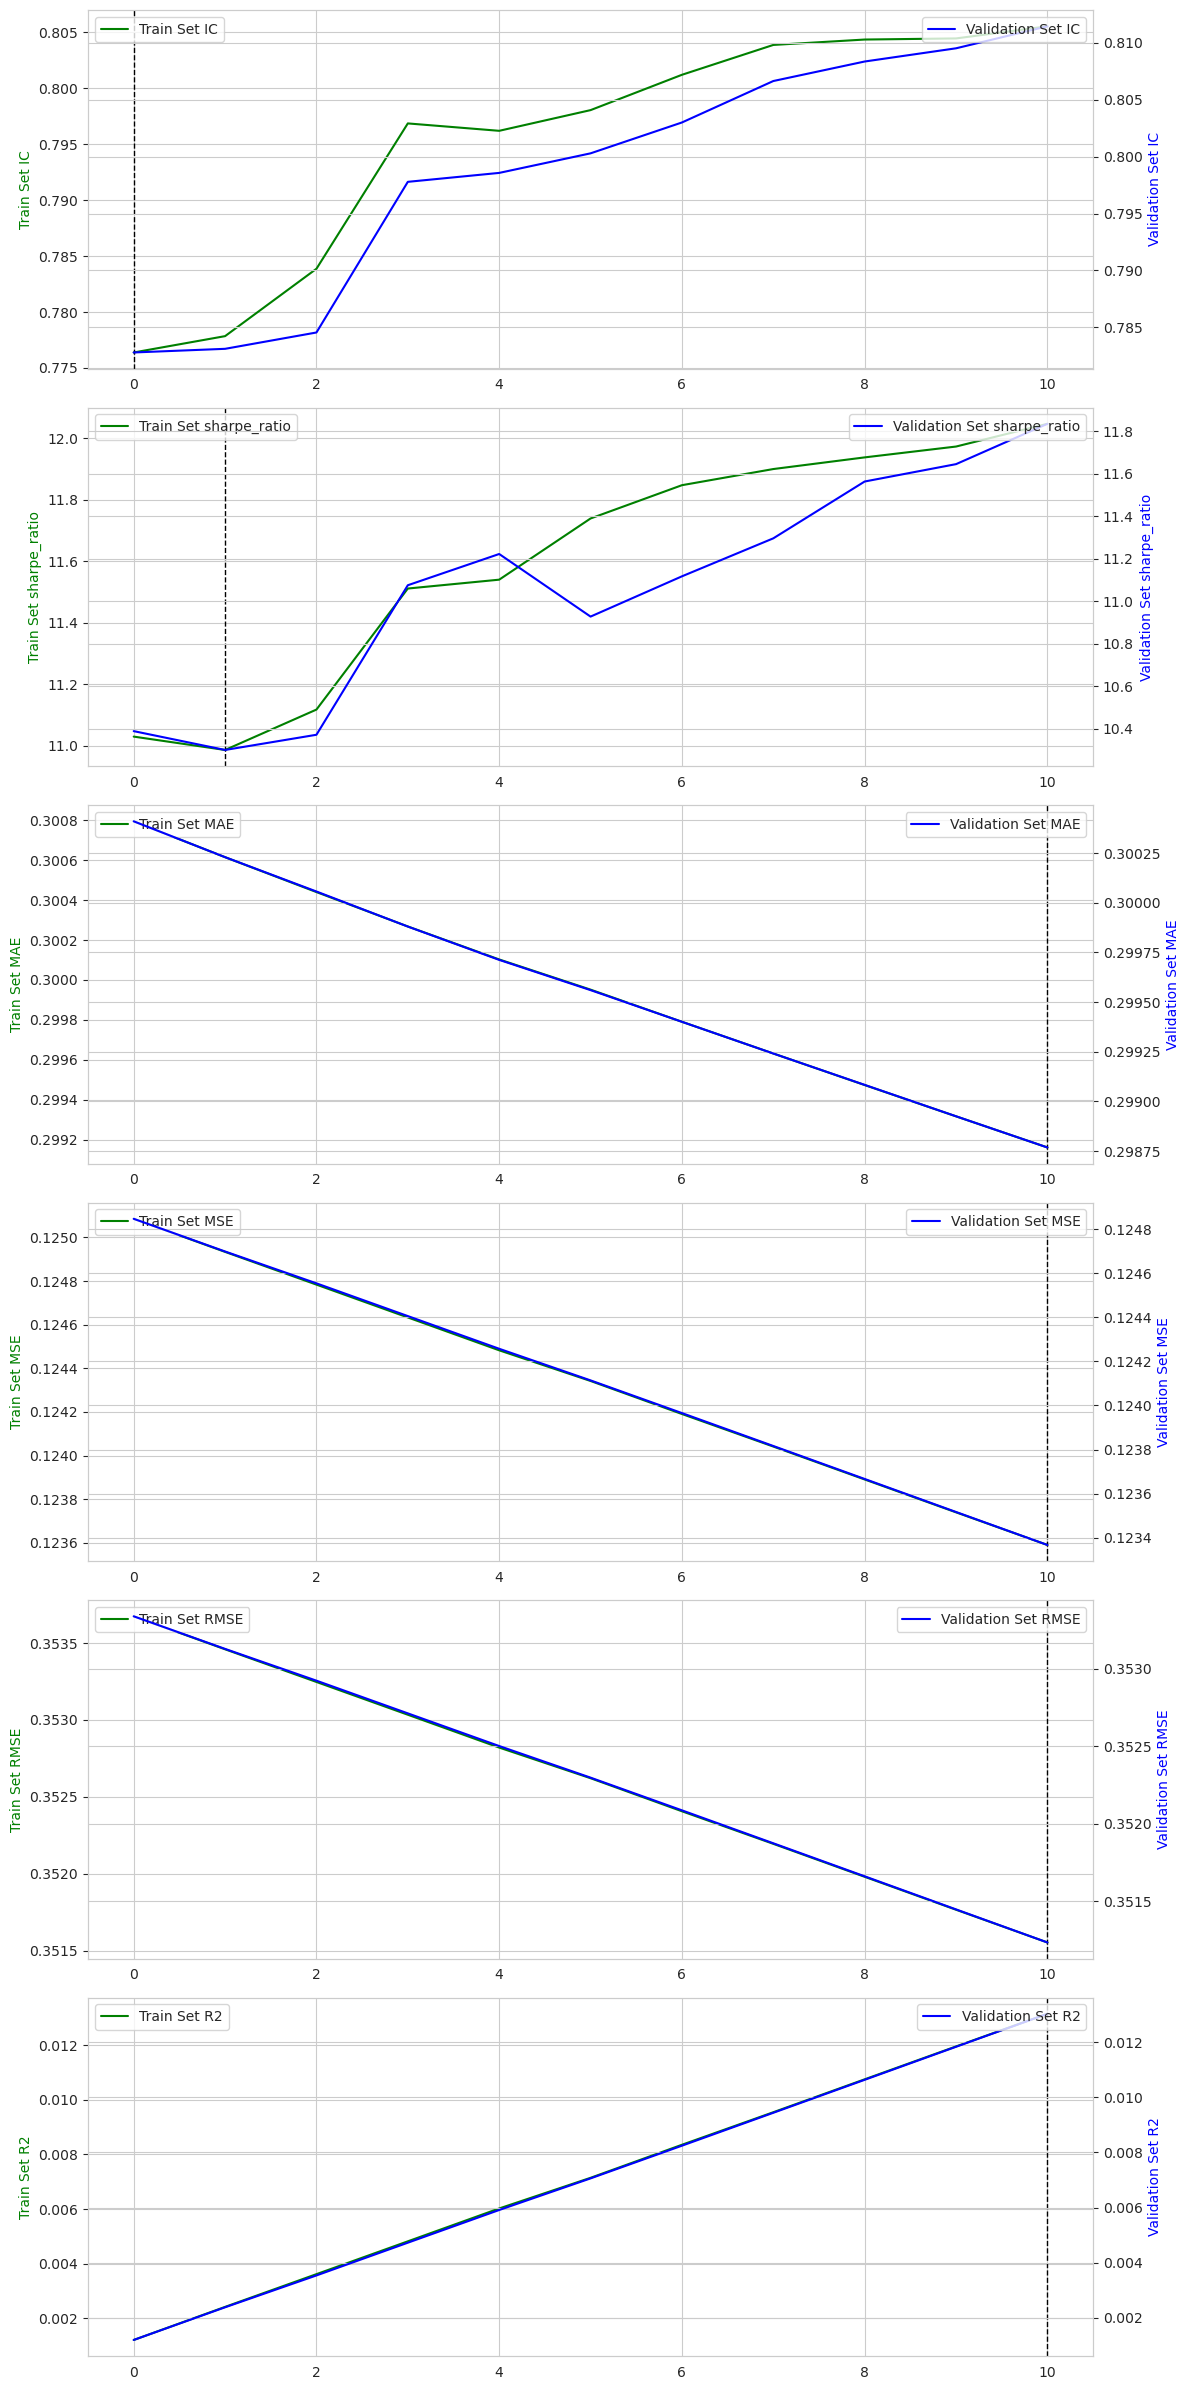

In [ ]:
# Assuming evals_result contains MAE, MSE, RMSE, R2 as well
metrics = ['IC', 'sharpe_ratio', 'MAE', 'MSE', 'RMSE', 'R2']

fig, axes = plt.subplots(len(metrics), 1, figsize=(12, 4 * len(metrics)))

for ax, metric in zip(axes, metrics):
    cv_result = pd.DataFrame({'Train Set': evals_result['train'][metric], 
                              'Validation Set': evals_result['valid_0'][metric]})
    
    ax1 = ax
    ax2 = ax1.twinx()  # instantiate a second axes sharing the same x-axis
    
    ax1.plot(cv_result.index, cv_result['Train Set'], 'g-', label=f'Train Set {metric}')
    ax2.plot(cv_result.index, cv_result['Validation Set'], 'b-', label=f'Validation Set {metric}')
    
    ax1.set_ylabel(f'Train Set {metric}', color='g')
    ax2.set_ylabel(f'Validation Set {metric}', color='b')
    
    if metric != 'R2':
        ax1.axvline(cv_result['Validation Set'].idxmin(), c='k', ls='--', lw=1)
    else:
        ax1.axvline(cv_result['Validation Set'].idxmax(), c='k', ls='--', lw=1)

    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
# Extract cat_threshold, lookahead, x, and val_period_length from best_params and remove them from the dictionary
cat_threshold = best_params.pop('cat_threshold', 50)  # default to 50 if not in best_params
best_lookahead = best_params.pop('lookahead', 1)  # default to 1 if not in best_params
best_x = best_params.pop('x', 8)  # default to 8 if not in best_params
best_val_period_length = best_params.pop('val_period_length', 5)  # default to 5 if not in best_params

# Construct the label column using the best lookahead
label = f'TARGET_ret_fwd_{best_lookahead:02d}d_rank_quantiled'
print(label)

# Determine the categorical columns based on cat_threshold
categoricals = [col for col in dataset.columns if dataset[col].nunique() < cat_threshold 
                and dataset[col].ge(0).all() and col.startswith("FEATURE_")]

# Create the training dataset
lgb_train_all = lgb.Dataset(data=dataset[features], label=dataset[label], 
                            categorical_feature=categoricals, free_raw_data=False)

# Remove any unrecognized parameters from best_params
best_params.pop('train_period_length', None)  # This might be needed if 'train_period_length' was included in best_params

# Add force_col_wise to the best_params
best_params['force_col_wise'] = True

# Determine the optimal number of boosting rounds from the previous training
optimal_boosting_rounds = evals_result['valid_0']['IC'].index(max(evals_result['valid_0']['IC']))
if optimal_boosting_rounds == 0:
    optimal_boosting_rounds = 1
    print(optimal_boosting_rounds)

# Train the final model with the best parameters
best_model = lgb.train(params=best_params,
                       train_set=lgb_train_all,
                       num_boost_round=optimal_boosting_rounds,  # Use the optimal number of rounds
                       feval=combined_fold_metrics,  # Updated feval
                       callbacks=[lgb.record_evaluation(evals_result)])

# Save or log the model if necessary
# For instance, using MLflow:
# mlflow.lightgbm.log_model(best_model, "final_lightgbm_model")

TARGET_ret_fwd_01d_rank_quantiled
[LightGBM] [Info] Total Bins 96040
[LightGBM] [Info] Number of data points in the train set: 486114, number of used features: 556
[LightGBM] [Info] Start training from score 0.502667


In [ ]:
from pathlib import Path

# Define the models folder path
models = Path("./models")

# Ensure the folder exists
models.mkdir(exist_ok=True)

import pickle

# Formulate the save path
save_path = models / f"{top}_combined_model_and_params_{label}.pkl"

# Save both model and parameters in a dictionary
with save_path.open("wb") as file:
    pickle.dump({
        "model": best_model,
        "params": best_params
    }, file)

print(f"Model and parameters saved to {save_path}")


Model and parameters saved to models/250_combined_model_and_params_TARGET_ret_fwd_01d_rank_quantiled.pkl


In [ ]:
best_lookahead

1

In [ ]:
# Remove the study database
os.remove("study/study.db")
print("Database has been deleted.")

Database has been deleted.


#### Test on unseen data

In [ ]:
from pathlib import Path
import pandas as pd
import lightgbm as lgb
from utils import rank_stocks_and_quantile
import pickle

def load_model_and_parameters(path):
    with open(path, 'rb') as file:
        loaded_object = pickle.load(file)
    return loaded_object['model'], loaded_object['params']


def read_and_process_data(store_path, key, target_substring):
    with pd.HDFStore(store_path) as store:
        data = store[key]
    data = rank_stocks_and_quantile(data, target_substring=target_substring)
    # data.index.set_levels(data.index.levels[0].tz_localize(None), level=0, inplace=True)
    new_index = data.index.set_levels(data.index.levels[0].tz_localize(None), level=0)
    data.set_index(new_index, inplace=True)

    return data


# def filter_by_date(data, look_ahead):
#     unique_dates = data.index.get_level_values('date').unique().sort_values()
#     cut_off_date = unique_dates[0] - pd.Timedelta(days=look_ahead)
#     return data[data.index.get_level_values('date') > cut_off_date]

def filter_by_date(data, look_ahead):
    unique_dates = data.index.get_level_values('date').unique().sort_values()
    
    # Ensure that there are enough unique dates for the look_ahead value
    assert len(unique_dates) > look_ahead, f"Insufficient unique dates for a look_ahead value of {look_ahead}"
    
    cut_off_date = unique_dates[look_ahead]
    
    return data[data.index.get_level_values('date') > cut_off_date]


def synchronize_and_merge_predictions(data, features, model, label):
    y_pred = model.predict(data[features])
    synchronized_labels = data[label][data[label].index.isin(data[features].index)]
    synchronized_y_pred = y_pred[:len(synchronized_labels)]

    preds = synchronized_labels.reset_index(name='actual').assign(predicted=\
        synchronized_y_pred).set_index(['date', 'ticker'])

    # Renaming and merging
    cols_to_rename = ['open', 'high', 'low', 'close', 'volume']
    new_col_names = ["FEATURE_" + col for col in cols_to_rename]
    rename_dict = dict(zip(cols_to_rename, new_col_names))

    data_renamed = data.rename(columns=rename_dict)
    preds = preds.reset_index().merge(data_renamed[new_col_names].reset_index(), \
        on=['ticker', 'date'], how='left')
    return preds[['date', 'ticker', 'actual', 'predicted'] \
        + new_col_names].set_index(['ticker', 'date'])


# Constants and Initial Setup
TOP = 250
UNSEEN_KEY = '/data/YEAR_20220803_20230803'
UNSEEN_STORE = Path(f'data/{TOP}_unseen_dataset.h5')
MODEL_PATH = "/home/sayem/Desktop/Project/models/250_combined_model_and_params_TARGET_ret_fwd_01d_rank_quantiled.pkl"

# Main Execution
best_model, params = load_model_and_parameters(MODEL_PATH)
test_data = read_and_process_data(UNSEEN_STORE, UNSEEN_KEY, 'TARGET_ret_fwd_')
filtered_test_data = filter_by_date(test_data, params.get('look_ahead', 1))
label = f'TARGET_ret_fwd_{params.get("look_ahead", 1):02d}d_rank_quantiled'
features = [col for col in test_data.columns if col.startswith('FEATURE_')]
preds = synchronize_and_merge_predictions(filtered_test_data, features, best_model, label)

preds.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 65484 entries, ('AA', Timestamp('2022-08-05 00:00:00')) to ('ZTS', Timestamp('2023-08-03 00:00:00'))
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   actual          65484 non-null  float64
 1   predicted       65484 non-null  float64
 2   FEATURE_open    65484 non-null  float32
 3   FEATURE_high    65484 non-null  float32
 4   FEATURE_low     65484 non-null  float32
 5   FEATURE_close   65484 non-null  float32
 6   FEATURE_volume  65484 non-null  float64
dtypes: float32(4), float64(3)
memory usage: 2.8+ MB


In [ ]:
preds.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 65484 entries, ('AA', Timestamp('2022-08-05 00:00:00')) to ('ZTS', Timestamp('2023-08-03 00:00:00'))
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   actual          65484 non-null  float64
 1   predicted       65484 non-null  float64
 2   FEATURE_open    65484 non-null  float32
 3   FEATURE_high    65484 non-null  float32
 4   FEATURE_low     65484 non-null  float32
 5   FEATURE_close   65484 non-null  float32
 6   FEATURE_volume  65484 non-null  float64
dtypes: float32(4), float64(3)
memory usage: 2.8+ MB


In [ ]:
from scipy.stats import spearmanr

def calculate_daily_spearman_correlation(group):
    """Calculate the daily Spearman correlation between actual and predicted values."""
    return spearmanr(group['actual'], group['predicted'])[0]

# Compute the daily Spearman correlation for each date
spearman_correlations_daily = preds.groupby('date').apply(calculate_daily_spearman_correlation)

# Calculate the average Spearman correlation over all dates
average_spearman_correlation = spearman_correlations_daily.mean()

# Calculate the Sharpe ratio for each date
daily_sharpe_ratios = spearman_correlations_daily / spearman_correlations_daily.std()

# Convert the Sharpe ratios to a DataFrame
sharpe_ratios_dataframe = daily_sharpe_ratios.to_frame()
sharpe_ratios_dataframe.columns = sharpe_ratios_dataframe.columns.astype(str)
sb.glue("sharpe_ratios_per_day", sharpe_ratios_dataframe, display=True)

,0
date,
2022-08-05,1.249913
2022-08-08,1.286323
2022-08-09,1.192418
2022-08-10,-0.485402
2022-08-11,0.380937
2022-08-12,0.403310
2022-08-15,0.375667
2022-08-16,1.436850
2022-08-17,-0.898223


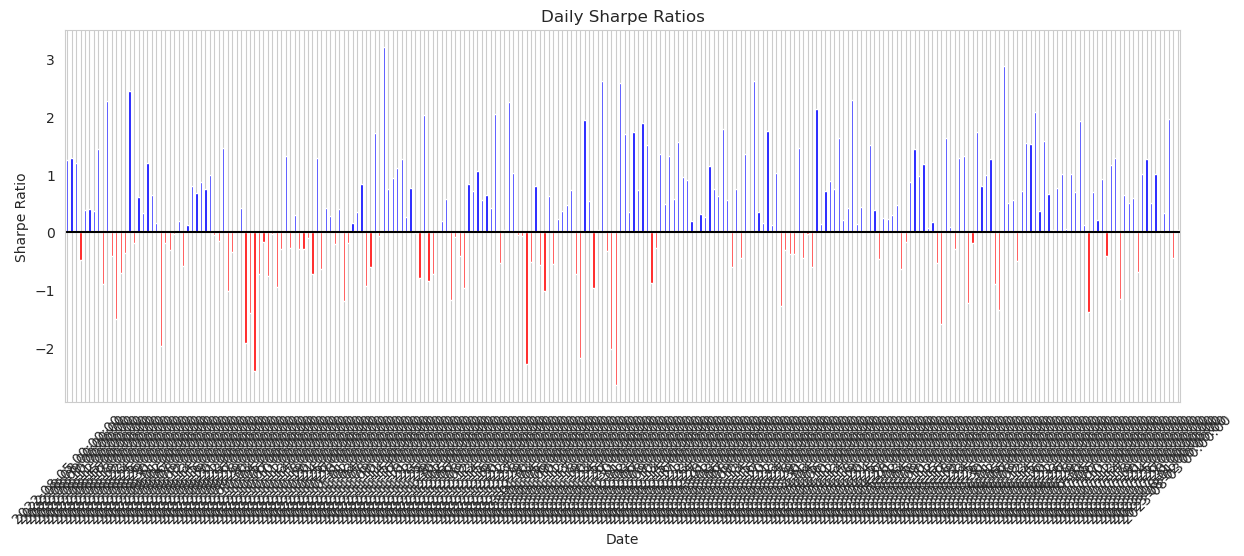

In [ ]:
import matplotlib.pyplot as plt

# Create a list of colors based on the sign of the Sharpe Ratios
colors = ['blue' if value > 0 else 'red' for value in daily_sharpe_ratios]

plt.figure(figsize=(12,6))
daily_sharpe_ratios.plot(kind='bar', color=colors)
plt.title('Daily Sharpe Ratios')
plt.xlabel('Date')
plt.ylabel('Sharpe Ratio')
plt.grid(axis='y')
plt.tight_layout()
plt.axhline(y=0, color='black', linestyle='-')  # Add a horizontal line at y=0
plt.xticks(rotation=45)  # Rotate the x-axis labels for better visibility
plt.show()


Dropped 36.4% entries from factor data: 4.0% in forward returns computation and 32.4% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 50.0%, not exceeded: OK!

Sharpe Ratios:
 1D     4.329612
5D     1.728503
10D    1.241273
dtype: float64
Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1.0,0.00,0.25,0.089518,0.119863,12221,30.745428
2.0,0.25,0.50,0.402813,0.121873,9065,22.805605
3.0,0.50,0.75,0.647483,0.122971,6138,15.441898
4.0,0.75,0.75,0.750000,0.000000,4435,11.157513
5.0,1.00,1.00,1.000000,0.000000,7890,19.849556


Returns Analysis


,1D,5D,10D
Ann. alpha,58.007,1.259,0.514
beta,0.012,0.033,0.045
Mean Period Wise Return Top Quantile (bps),211.850,44.199,23.319
Mean Period Wise Return Bottom Quantile (bps),-172.829,-33.861,-16.566
Mean Period Wise Spread (bps),384.679,78.025,39.849


<Figure size 640x480 with 0 Axes>

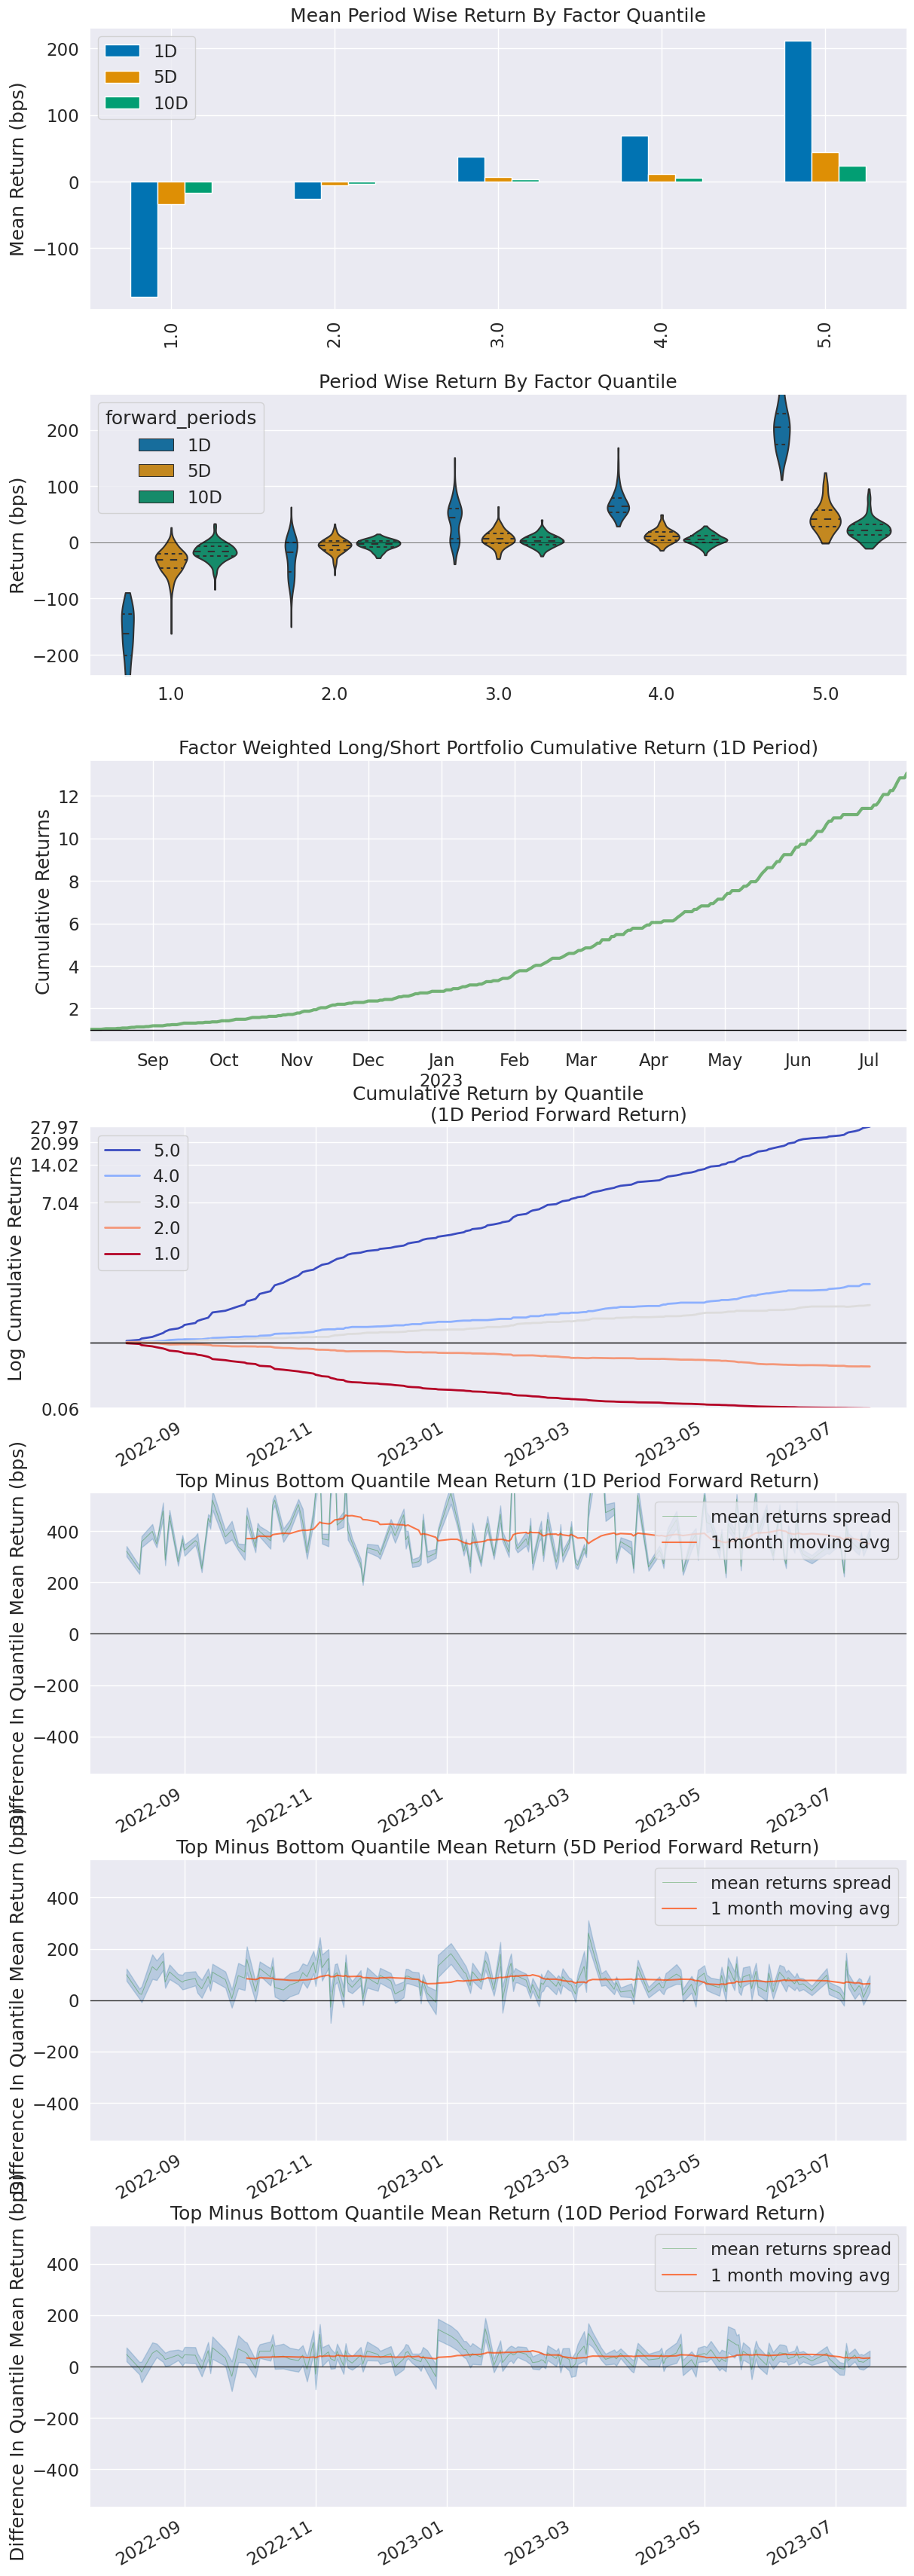

Information Analysis


,1D,5D,10D
IC Mean,0.976,0.379,0.271
IC Std.,0.006,0.170,0.180
Risk-Adjusted IC,169.113,2.232,1.503
t-stat(IC),NaN,NaN,NaN
p-value(IC),NaN,NaN,NaN
IC Skew,NaN,NaN,NaN
IC Kurtosis,NaN,NaN,NaN


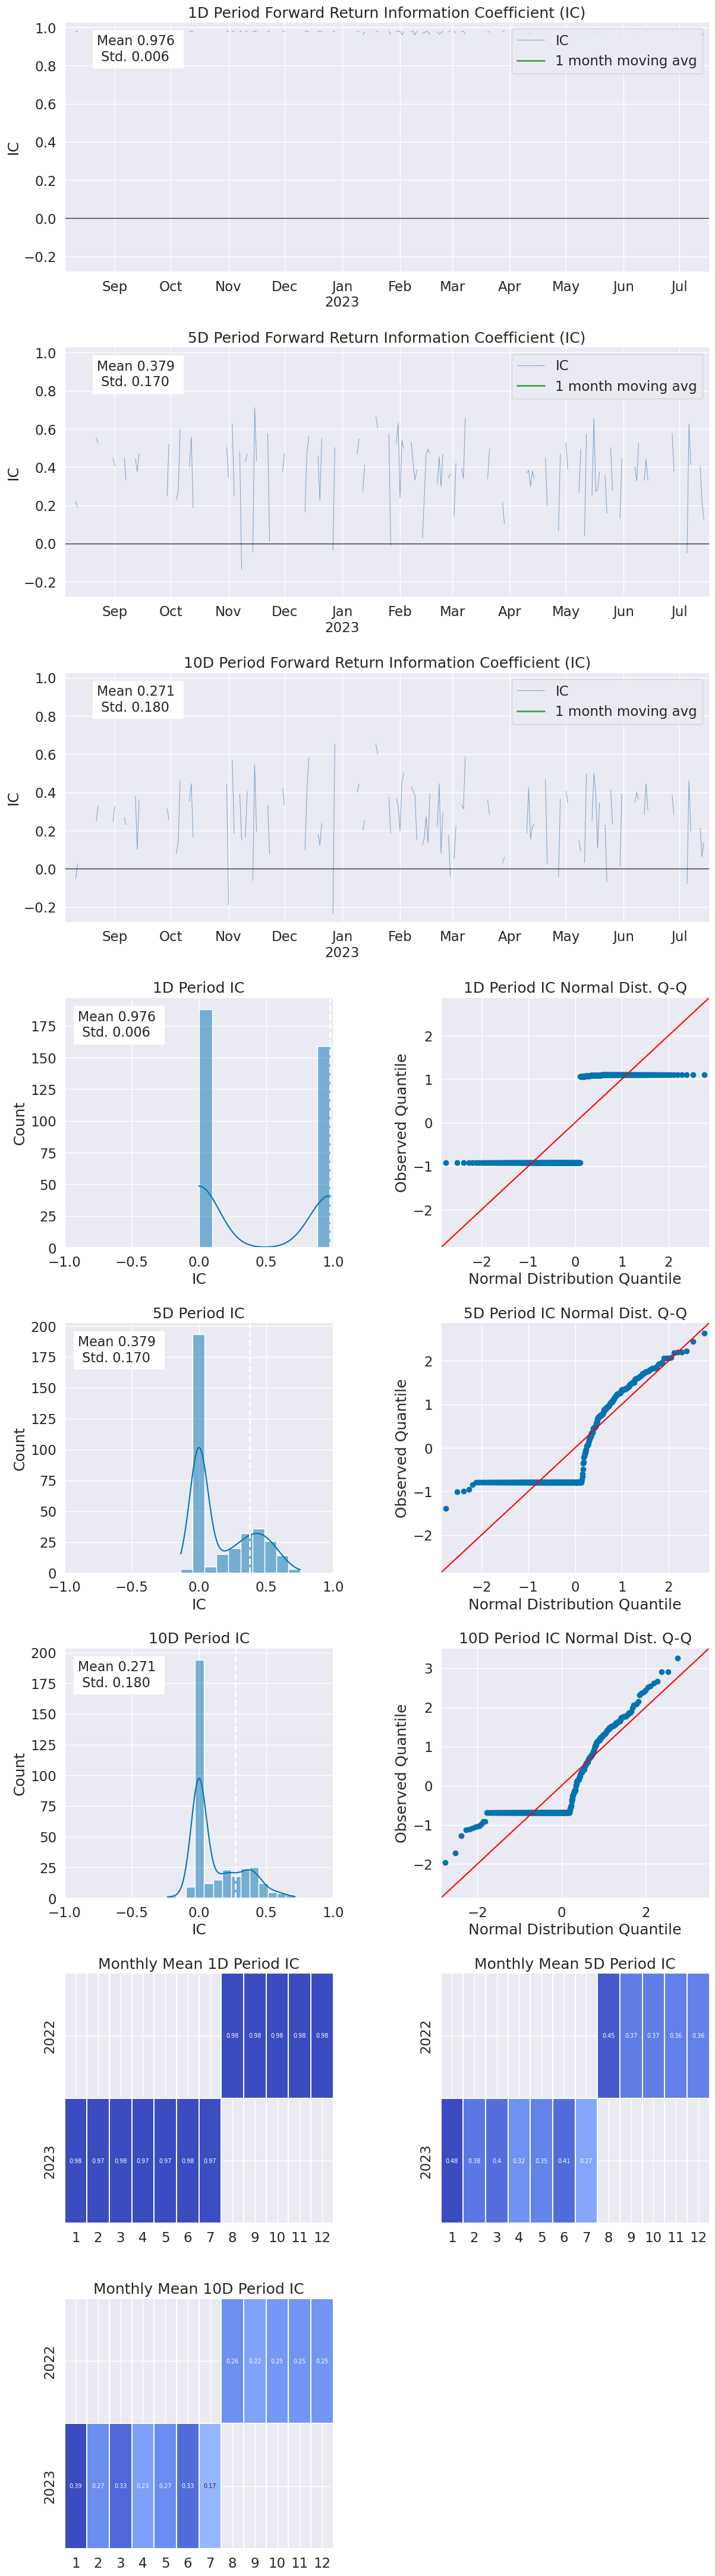

Turnover Analysis


,1D,5D,10D
Quantile 1.0 Mean Turnover,0.694,0.671,0.711
Quantile 2.0 Mean Turnover,0.758,0.759,0.763
Quantile 3.0 Mean Turnover,0.783,0.758,0.769
Quantile 4.0 Mean Turnover,0.814,0.786,0.779
Quantile 5.0 Mean Turnover,0.768,0.774,0.776


,1D,5D,10D
Mean Factor Rank Autocorrelation,-0.014,-0.011,0.025


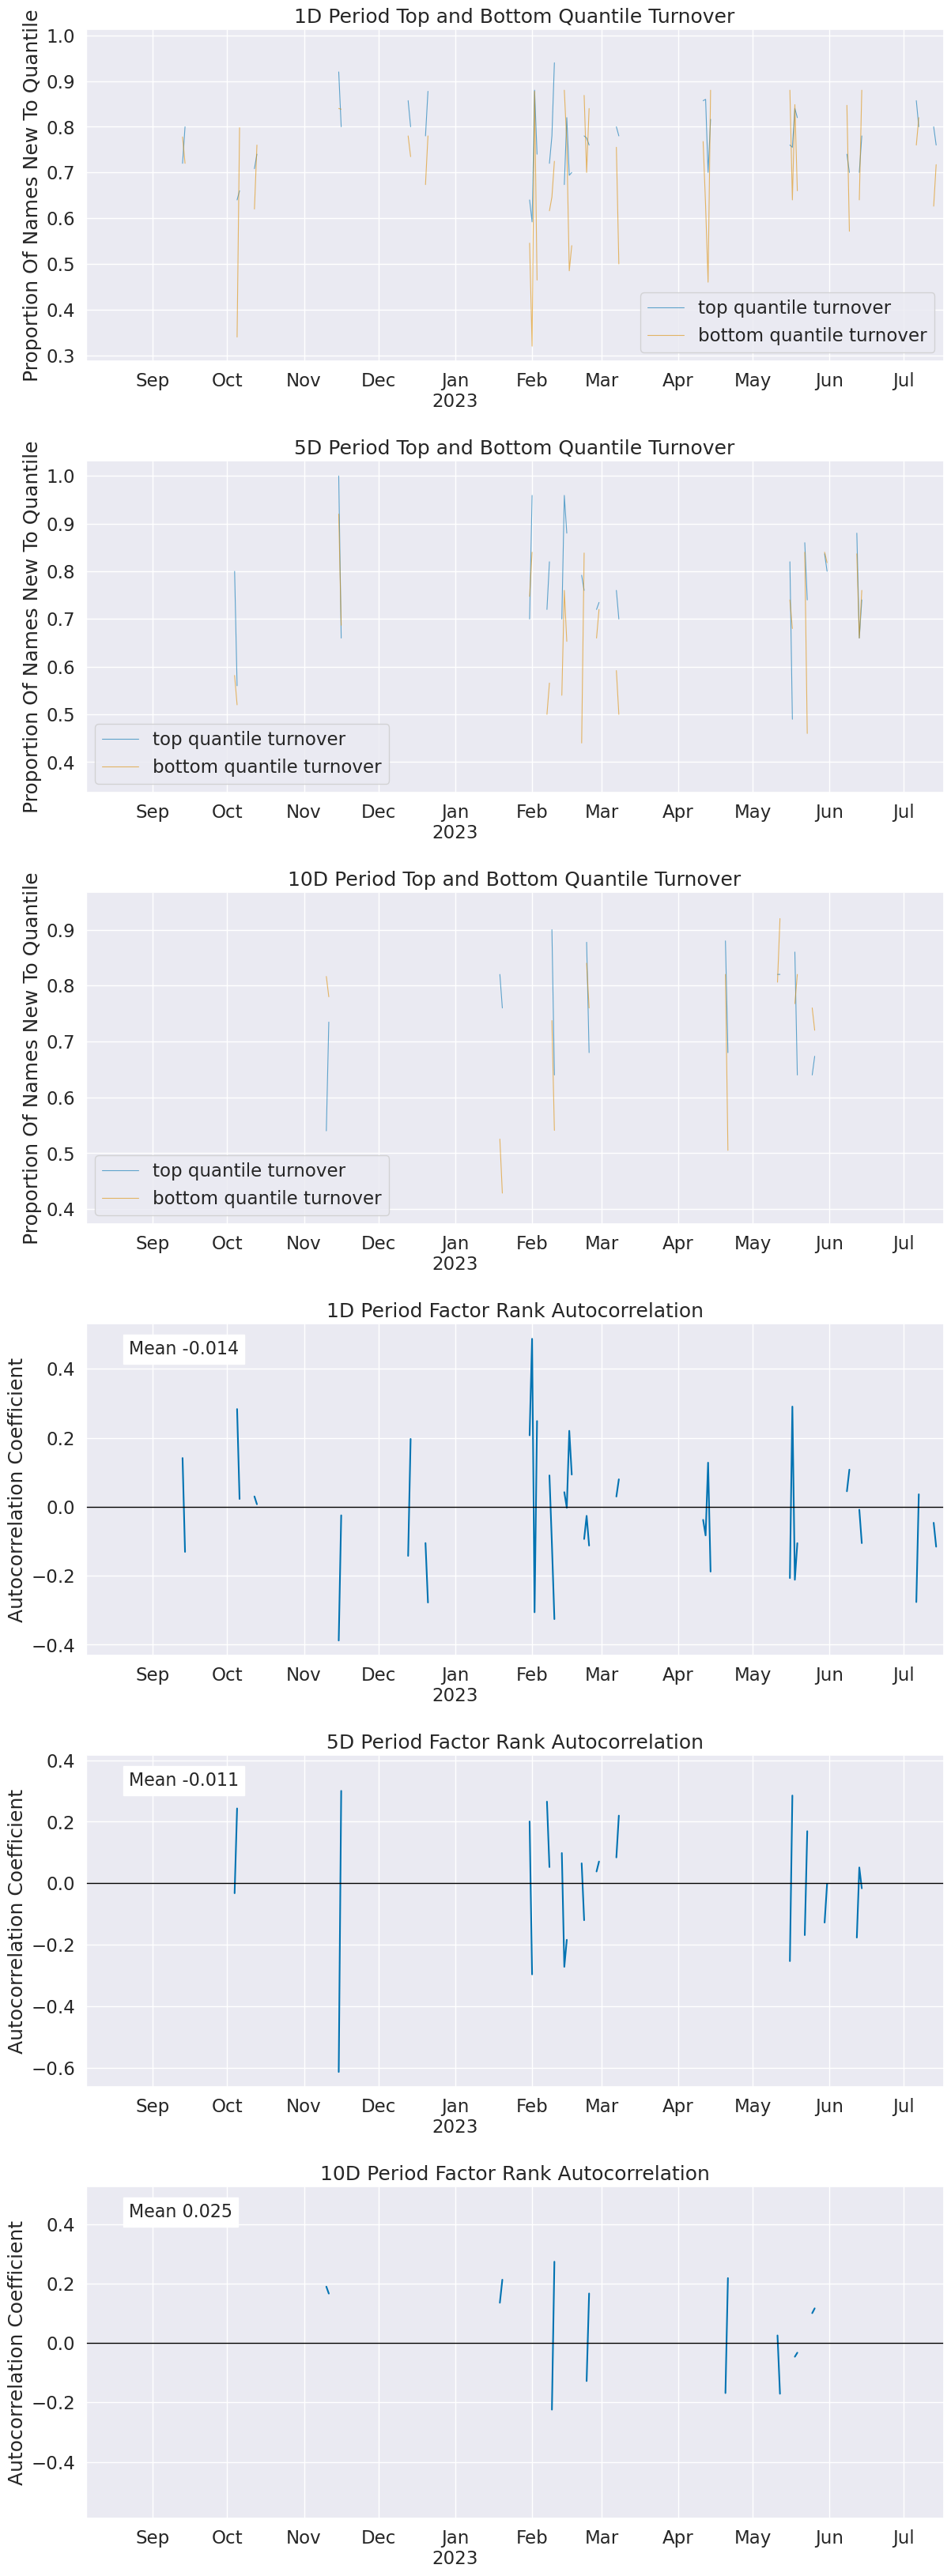

In [ ]:
# import pandas as pd
# import alphalens as al

# def generate_alphalens_tearsheet(df: pd.DataFrame, label_col: str, price_col: str) -> None:
#     """
#     Generate the Alphalens full tearsheet given the input dataframe, 
#     label column, and price data column.
#     """
#     # Extract the factor and trade_prices series
#     factor = df[label_col]
#     trade_prices = df[price_col]
    
#     # Remove duplicated indices from factor and trade_prices
#     factor = factor[~factor.index.duplicated(keep='first')]
#     trade_prices = trade_prices[~trade_prices.index.duplicated(keep='first')]
    
#     # Convert the trade_prices series into unstacked format
#     trade_prices_unstacked = trade_prices.unstack(level='ticker')
    
#     # Ensure the factor's DatetimeIndex level has the same timezone as trade_prices_unstacked
#     if isinstance(factor.index, pd.MultiIndex):
#         level_0 = factor.index.get_level_values(0)
#         if hasattr(level_0, 'tz') and level_0.tz is not None:
#             if level_0.tz != trade_prices_unstacked.index.tz:
#                 factor.index.set_levels(level_0.tz_convert(trade_prices_unstacked.index.tz), \
#                     level=0, inplace=True)
#         factor = factor.swaplevel().sort_index()
#     else:
#         if hasattr(factor.index, 'tz') and factor.index.tz is not None:
#             if factor.index.tz != trade_prices_unstacked.index.tz:
#                 factor.index = factor.index.tz_convert(trade_prices_unstacked.index.tz)

#     # Create the factor_data dataframe with forward returns
#     alphalen_analysis = al.utils.get_clean_factor_and_forward_returns(
#         factor=factor,
#         prices=trade_prices_unstacked,
#         periods=[1, 5, 10],
#         max_loss=0.5
#     )
#     factor_returns = al.performance.factor_returns(alphalen_analysis)
#     sharpe_ratios = factor_returns.mean() / factor_returns.std()

#     print("\nSharpe Ratios:\n", sharpe_ratios)
#     alphalen_analysis = alphalen_analysis[~alphalen_analysis.index.duplicated(keep='first')]
#     alphalen_analysis = alphalen_analysis.groupby(level=[0, 1]).mean()
#     return alphalen_analysis

# # target = 'actual'
# alphalens_analysis = generate_alphalens_tearsheet(preds, \
#     label_col='actual', price_col='FEATURE_close')

# import alphalens as al
# al.tears.create_full_tear_sheet(alphalens_analysis)